# FICORO_GNSS
## Filter, combine and rotate GNSS velocity fields
### Nicolás Castro-Perdomo, 2023

### Step 1: Define input & output parameters

In [2]:
"""Master script to filter and combine GPS velocity fields"""

# Import libraries and define paths and parameters
import os
import subprocess
import datetime
import shutil
import sys
import glob
import pandas as pd
import numpy as np
import pygmt

# Input parameters
input_path = "raw_input"
output_path = "raw_input_column_formatted"
input_file_ext = "raw"
output_file_ext = "vel"
scripts_path = "scripts"
results_path = "results"
igb_nocomb_path = "igb14_no_comb"
igb_nocomb_subpath = "igb14"

lognorm_script_path = os.path.join(scripts_path, "lognorm_filter.py")
coherence_script_path = os.path.join(scripts_path, "coherence_filter.py")
combination_script_path = os.path.join(scripts_path, "combine_vel.py")
plot_maps_filter_path = os.path.join(scripts_path, "plot_maps_filtering.py")
coherence_results_path = os.path.join(results_path, "output_coherence_analysis")
input_files_rot_path = os.path.join(results_path, "input_files_rotation")
ITRF14_vel_path = os.path.join(results_path, "rotation_steps")
lnk_file = "velrot.lnk"
lnk_folder_path = "./rotation_lnk_file"
lnk_file_path = os.path.join(lnk_folder_path, lnk_file)
reference_vel = "serpelloni_2022.vel"
reference_vel_path = os.path.join(input_files_rot_path, reference_vel)
temp_combined_folder_path = os.path.join(results_path, "combined_velocities")
plot_rotated_script_path = os.path.join(scripts_path, "plot_rotated_vels.py")

print("------------------------------------------------------------------------------------")
print(f"                    FICORO_GPS executed on: {datetime.datetime.now().strftime('%Y-%m-%d, %H:%M:%S')}               ")
print("------------------------------------------------------------------------------------")
print(" Description: Master script to filter and combine GPS velocity fields ")
print(" Translates raw velocity tables into GAMIT/GLOBK compatible .vel files              ")
print(" Calls python scripts to clean individual velocity fields and combines them using   ")
print(" the GAMIT/GLOBK script cvframe and rotates the combined solution using VELROT     ")
print(" Default parameters:                                                                ")
print(f" - Input path, raw velocity files= {input_path}/                                     ")
print(" Headers: Lon Lat E.vel N.vel E.adj N.adj E.sig N.sig Corr U.vel U.adj U.sig Sta  ")
print("------------------------------------------------------------------------------------")
print()

------------------------------------------------------------------------------------
                    FICORO_GPS executed on: 2023-09-30, 00:10:05               
------------------------------------------------------------------------------------
 Description: Master script to filter and combine GPS velocity fields 
 Translates raw velocity tables into GAMIT/GLOBK compatible .vel files              
 Calls python scripts to clean individual velocity fields and combines them using   
 the GAMIT/GLOBK script cvframe and rotates the combined solution using VELROT     
 Default parameters:                                                                
 - Input path, raw velocity files= raw_input/                                     
 Headers: Lon Lat E.vel N.vel E.adj N.adj E.sig N.sig Corr U.vel U.adj U.sig Sta  
------------------------------------------------------------------------------------



### Step 2: Load input velocity fields

In [2]:
# Column formatting routine
print("------------------------------------------------------------------------------------")
print("                               Checking input files                                 ")
print("------------------------------------------------------------------------------------")
print()

# Check if the input path exists
if not os.path.exists(input_path):
    print(f"Input path '{input_path}' does not exist. Terminating.")
    exit(1)

# Check if the input path is empty
if not os.listdir(input_path):
    print("Input folder is empty. Terminating.")
    exit(1)

# Check if the output path exists
if os.path.exists(output_path):
    # Remove the files inside the output path
    for file in os.listdir(output_path):
        file_path = os.path.join(output_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
else:
    # Create the output path if it doesn't exist
    os.makedirs(output_path)

# Loop through each input file in the input path
for input_file in os.listdir(input_path):
    if input_file.endswith("." + input_file_ext):
        base = os.path.splitext(input_file)[0]
        print(f"Translating {base}.{input_file_ext} into {base}.{output_file_ext}")
        with open(os.path.join(input_path, input_file), "r") as input_file:
            lines = input_file.readlines()
            lines = [line.strip().split() for line in lines]
            header = "Lon Lat E.vel N.vel E.adj N.adj E.sig N.sig Corr U.vel U.adj U.sig Stat"
            formatted_lines = [header] + [" ".join(line) for line in lines]
            output_file_path = os.path.join(output_path, f"{base}.{output_file_ext}")
            with open(output_file_path, "w") as output_file:
                output_file.write("\n".join(formatted_lines))

------------------------------------------------------------------------------------
                               Checking input files                                 
------------------------------------------------------------------------------------

Translating euref_all.raw into euref_all.vel
Translating mcclusky_2010.raw into mcclusky_2010.vel
Translating billi_2023.raw into billi_2023.vel
Translating sokhadze_2018.raw into sokhadze_2018.vel
Translating nocquet_2012.raw into nocquet_2012.vel
Translating england_2016.raw into england_2016.vel
Translating kurt_2023.raw into kurt_2023.vel
Translating viltres_2022.raw into viltres_2022.vel
Translating viltres_2020.raw into viltres_2020.vel
Translating hamiel_2021.raw into hamiel_2021.vel
Translating pinaValdes_2022.raw into pinaValdes_2022.vel
Translating ozkan_2022.raw into ozkan_2022.vel
Translating briole_2021.raw into briole_2021.vel
Translating reilinger_2006.raw into reilinger_2006.vel
Translating alchalbi_2013.raw into alcha

### Step 3: Identify and remove outliers 

In [3]:
# Running GNSS velocity cleaning/filtering scripts
print() 
print("------------------------------------------------------------------------------------")
print("                          Cleaning GNSS velocity fields                             ")
print("------------------------------------------------------------------------------------")
print()                

# Execute lognorm filter script
if os.path.exists(lognorm_script_path):
    input_lognorm_path = "./raw_input_column_formatted"
    output_lognorm_path = "./results/output_lognorm_99_filtered"
    excluded_lognorm_path = "./results/sites_excluded_lognorm_99"
    figure_folder_path = "./results/figures"
    
    subprocess.run(["python", lognorm_script_path, input_lognorm_path, output_lognorm_path, excluded_lognorm_path, figure_folder_path])
else:
    print(f"Error: {lognorm_script_path} not found. Terminating")
    exit(1)

print()     

# Execute coherence filter script
if os.path.exists(coherence_script_path):
    subprocess.run(["python", coherence_script_path, output_lognorm_path])
else:
    print(f"Error: {coherence_script_path} not found. Terminating")
    exit(1)


------------------------------------------------------------------------------------
                          Cleaning GNSS velocity fields                             
------------------------------------------------------------------------------------

########## Removing outliers based on lognorm uncertainty distribution ###########
----------------------------------------------------------------------------------
Number of stations removed for saleh_2015: 2 / 149 (1.34%)
Sites excluded: ./results/sites_excluded_lognorm_99/saleh_2015.csv
Filtered velocities: ./results/output_lognorm_99_filtered/saleh_2015.csv
Saving figure for saleh_2015...
----------------------------------------------------------------------------------
Number of stations removed for pinaValdes_2022: 81 / 4837 (1.67%)
Sites excluded: ./results/sites_excluded_lognorm_99/pinaValdes_2022.csv
Filtered velocities: ./results/output_lognorm_99_filtered/pinaValdes_2022.csv
Saving figure for pinaValdes_2022...
----------

### Step 4: Plot filtered GNSS velocities and outliers

In [4]:
# Running map plotting scripts
print() 
print("------------------------------------------------------------------------------------")
print("                          Plotting GNSS velocity fields                             ")
print("------------------------------------------------------------------------------------")
print()  

# Execute plot maps filtering script
if os.path.exists(plot_maps_filter_path):
    subprocess.run(["python", plot_maps_filter_path])
else:
    print(f"Error: {plot_maps_filter_path} not found. Terminating")
    exit(1)


------------------------------------------------------------------------------------
                          Plotting GNSS velocity fields                             
------------------------------------------------------------------------------------

Plotting GPS velocities for reilinger_2006 data set
Plotting GPS velocities for briole_2021 data set
Plotting GPS velocities for pinaValdes_2022 data set
Plotting GPS velocities for ozkan_2022 data set
Plotting GPS velocities for alchalbi_2013 data set
Plotting GPS velocities for saleh_2015 data set
Plotting GPS velocities for euref_all data set
Plotting GPS velocities for nocquet_2012 data set
Plotting GPS velocities for sokhadze_2018 data set
Plotting GPS velocities for mcclusky_2010 data set
Plotting GPS velocities for billi_2023 data set
Plotting GPS velocities for england_2016 data set
Plotting GPS velocities for kurt_2023 data set
Plotting GPS velocities for viltres_2022 data set
Plotting GPS velocities for hamiel_2021 data set

### Step 5: Align velocity fields to ITRF14 using GAMIT's velrot script

In [5]:
# Column formatting routine for cvframe/velrot compatibility

# Check if the input folder is empty
if not os.listdir(coherence_results_path):
    print("Input folder is empty. Terminating.")
    exit(1)

# Check if the folder containing input files for rotation exists
if os.path.exists(input_files_rot_path):
    # Remove all contents of the input_files_rot_path folder
    for file in os.listdir(input_files_rot_path):
        file_path = os.path.join(input_files_rot_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
else:
    # Create the input_files_rot_path folder if it doesn't exist
    os.makedirs(input_files_rot_path)

# Loop through each csv file in the input folder
for file in os.listdir(coherence_results_path):
    if file.endswith(".csv"):
        input_file_path = os.path.join(coherence_results_path, file)
        output_file_path = os.path.join(input_files_rot_path, os.path.splitext(file)[0] + ".vel")
        with open(input_file_path, "r") as input_file:
            lines = input_file.readlines()
            lines = [line.strip() for line in lines[1:]]
            formatted_lines = [" " + line for line in lines]
            with open(output_file_path, "w") as output_file:
                output_file.write("\n".join(formatted_lines))

# Aligning velocity fields to ITRF14
print()
print("--------------------------------------------------------------")
print("              Aligning velocity fields to ITRF14              ")
print("--------------------------------------------------------------")
print()

# Check if the input folder is empty
if not os.listdir(input_files_rot_path):
    print("Input folder is empty. Terminating.")
    exit(1)

# Check if the folder containing ITRF14-rotated velocities exists
if os.path.exists(ITRF14_vel_path):
    # Remove all contents of the ITRF14_vel_path folder
    for file in os.listdir(ITRF14_vel_path):
        file_path = os.path.join(ITRF14_vel_path, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
else:
    # Create the ITRF14_vel_path folder if it doesn't exist
    os.makedirs(ITRF14_vel_path)

if not os.path.exists(lnk_file_path):
    print(f"Creating {lnk_file}...")
    os.makedirs(lnk_folder_path, exist_ok=True)
    with open(lnk_file_path, "w") as lnk_file:
        lnk_file.write(" " + "eq_dist 1000\n")

if not os.path.exists(reference_vel_path):
    print(f"Error: The reference velocity file {reference_vel_path} does not exist.")
    exit(1)
            
print("Formatting files before alignment to ITRF14 completed")

top_pattern = "SYSTEM 1 Velocities transformed to SYSTEM 2"
bot_pattern = "SYSTEM 2 Velocities except those in SYSTEM 1"

# Assign the link file name as a string
lnk_file_str = "velrot.lnk"

# Loop through each .vel file in the input folder
for vel_file in os.listdir(input_files_rot_path):
    if vel_file.endswith(".vel"):
        base = os.path.splitext(vel_file)[0]
        folder_path = os.path.join(ITRF14_vel_path, base)
        os.makedirs(folder_path)

        shutil.copy(os.path.join(input_files_rot_path, vel_file), folder_path)
        shutil.copy(reference_vel_path, folder_path)
        shutil.copy(lnk_file_path, folder_path)
        
        # Avoid rotating the reference velocity field with respect to itself
        
        if base == os.path.splitext(reference_vel)[0]:
            # Rename the reference velocity file to _igb14.vel
            os.rename(
                os.path.join(folder_path, reference_vel),
                os.path.join(folder_path, f"{base}_igb14.vel")
            )
        else:
            
            # Run the velrot command and capture output
            cmd = [
                "velrot", f"{base}.vel", "NONE", reference_vel,
                "NONE", f"{base}_igb14.tmp", "NONE", lnk_file_str, "0", "TR"
            ]
            log_file_path = os.path.join(folder_path, f"{base}_align.log")

            with open(log_file_path, "w") as log_file:
                subprocess.run(cmd, cwd=folder_path, stdout=log_file, stderr=subprocess.STDOUT)


            # Process the rotated file
            rotated_tmp_file = os.path.join(folder_path, f"{base}_igb14.tmp")
            rotated_vel_file = os.path.join(folder_path, f"{base}_igb14.vel")

            # Read the contents of the temporary rotated file
            with open(rotated_tmp_file, "r") as tmp_file:
                tmp_lines = tmp_file.readlines()

            # Extract the lines between top and bottom patterns, remove the first 2 lines and the last line
            start_idx = next(i for i, line in enumerate(tmp_lines) if top_pattern in line)
            end_idx = next(i for i, line in enumerate(tmp_lines) if bot_pattern in line)
            extracted_lines = tmp_lines[start_idx + 1:end_idx - 1]
            extracted_lines = extracted_lines[2:]

            # Remove '*' characters from lines
            cleaned_lines = [line.replace("*", "").rstrip() for line in extracted_lines]

            # Write the cleaned lines to the rotated velocity file
            with open(rotated_vel_file, "w") as vel_file:
                vel_file.write("\n".join(cleaned_lines))

# Copying rotated velocity files to igb14_no_comb/igb14

# Create igb14_no_comb folder if it doesn't exist
igb_nocomb_parent_folder = os.path.join(results_path, igb_nocomb_path)
if not os.path.exists(igb_nocomb_parent_folder):
    os.makedirs(igb_nocomb_parent_folder)

# Create the igb14 if it doesn't exist
igb_nocomb_subfolder = os.path.join(igb_nocomb_parent_folder, igb_nocomb_subpath)
if not os.path.exists(igb_nocomb_subfolder):
    os.makedirs(igb_nocomb_subfolder)

# Loop through each folder in the ITRF14_vel_path
for folder in os.listdir(ITRF14_vel_path):
    folder_path = os.path.join(ITRF14_vel_path, folder)
    if os.path.isdir(folder_path):
        folder_name = os.path.basename(folder_path)

        # Check if the folder contains the desired file
        igb14_vel_file = os.path.join(folder_path, f"{folder_name}_igb14.vel")
        if os.path.exists(igb14_vel_file):
            # Copy the file to the igb_nocomb_subpath
            shutil.copy(igb14_vel_file, igb_nocomb_subfolder)

print("Alignment to igb14 completed. Rotated files copied to igb14_no_comb/igb14")


--------------------------------------------------------------
              Aligning velocity fields to ITRF14              
--------------------------------------------------------------

Creating velrot.lnk...
Formatting files before alignment to ITRF14 completed
Alignment to igb14 completed. Rotated files copied to igb14_no_comb/igb14


### Step 6: Rotate velocity fields using Euler poles

In [6]:
# Rotating reference frames using Euler poles
print()
print("--------------------------------------------------------------")
print("  Rotating reference frames using Euler poles  ")
print("--------------------------------------------------------------")
print()

# Set the destination folder paths
arab_dest_folder = os.path.join(results_path, igb_nocomb_path, "arab")
eura_dest_folder = os.path.join(results_path, igb_nocomb_path, "eura")
nubi_dest_folder = os.path.join(results_path, igb_nocomb_path, "nubi")
sina_dest_folder = os.path.join(results_path, igb_nocomb_path, "sina")
anat_dest_folder = os.path.join(results_path, igb_nocomb_path, "anat")
igb14_dest_folder = os.path.join(results_path, igb_nocomb_path, igb_nocomb_subpath)

# Create the destination folders
os.makedirs(arab_dest_folder, exist_ok=True)
os.makedirs(eura_dest_folder, exist_ok=True)
os.makedirs(nubi_dest_folder, exist_ok=True)
os.makedirs(sina_dest_folder, exist_ok=True)
os.makedirs(anat_dest_folder, exist_ok=True)

# Define the Euler pole parameters for each rotation
euler_poles = {
    "arab": "0.32840 -0.03504 0.40682", # Arabia Euler Pole by Viltres et al. (2022)
    "sina": "0.24250 -0.04797 0.34939", # Sinai Euler Pole by Hamiel et al. (2021)
    "anat": "1.008722 0.543127 1.020384", # Anatolia Euler Pole by Ergintav et al. (2023)
    "nubi": "NUBI_I14", # Nubia Euler Pole, ITRF14 by Altamimi et al. (2016)
    "eura": "EURA_I14" # Eurasia Euler Pole, ITRF14 by Altamimi et al. (2016)
}

# Loop through each .vel file in the IGB14 folder
for velfile in os.listdir(igb14_dest_folder):
    if velfile.endswith(".vel"):
        base = os.path.splitext(velfile)[0]
        new_base = base.replace("_igb14", "")

        # Loop through each reference frame and rotate the .vel file
        for ref_frame, euler_params in euler_poles.items():
            output_vel_name = f"{new_base}_{ref_frame}.vel"

            # Skip the reference frame itself
            if ref_frame == "igb14":
                continue

            # Run cvframe command to rotate the .vel file
            cmd = [
                "cvframe", velfile, output_vel_name, "ITRF14", euler_params
            ]
            subprocess.run(
                cmd, cwd=igb14_dest_folder,
                stdout=subprocess.PIPE, stderr=subprocess.PIPE
            )

            # Move the rotated file to the destination folder
            dest_folder = (
                arab_dest_folder if ref_frame == "arab" else
                eura_dest_folder if ref_frame == "eura" else
                nubi_dest_folder if ref_frame == "nubi" else
                sina_dest_folder if ref_frame == "sina" else
                anat_dest_folder
            )
            shutil.move(
                os.path.join(igb14_dest_folder, output_vel_name),
                os.path.join(dest_folder, output_vel_name)
            )

print("Rotation using Euler poles completed")


--------------------------------------------------------------
  Rotating reference frames using Euler poles  
--------------------------------------------------------------

Rotation using Euler poles completed


### Step 7: Combine velocity fields

In [7]:
import concurrent.futures
# Combining rotated velocity fields
print("--------------------------------------------------------------")
print("               Combining rotated velocity fields              ")
print("--------------------------------------------------------------")
print()

# Function to combine GNSS velocities 
def combine_velocities(ref_frame):
    print(f"Combining GPS velocities in {ref_frame}-fixed reference frame ...")
    ref_frame_folder = os.path.join(results_path, igb_nocomb_path, ref_frame)
    subprocess.run([
        "python", combination_script_path, ref_frame_folder, temp_combined_folder_path
    ])

# Run combination script in Python using concurrent.futures.ThreadPoolExecutor
if os.path.exists(combination_script_path):
    total_workers = len(euler_poles) + 1 # Number of reference frames + 1 for IGB14

    print(f"Running combination script in parallel using {total_workers} workers")
    print("--------------------------------------------------------------")
    print()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=total_workers) as executor:
        # Map the function for each reference frame including IGB14
        executor.map(combine_velocities, euler_poles.keys())
        combine_velocities("igb14")  # Combining for IGB14 reference frame
else:
    print(f"Error: {combination_script_path} not found. Terminating")
    sys.exit(1)

--------------------------------------------------------------
               Combining rotated velocity fields              
--------------------------------------------------------------

Running combination script in parallel using 6 workers
--------------------------------------------------------------

Combining GPS velocities in arab-fixed reference frame ...
Combining GPS velocities in sina-fixed reference frame ...
Combining GPS velocities in anat-fixed reference frame ...
Combining GPS velocities in nubi-fixed reference frame ...
Combining GPS velocities in eura-fixed reference frame ...
Combining GPS velocities in igb14-fixed reference frame ...
Number of groups of close stations: 8546
Number of groups of close stations: 8546
Number of groups of close stations: 8546
Number of groups of close stations: 8546
Number of groups of close stations: 8546
Number of groups of close stations: 8546
Time taken to combine GNSS velocity fields: 6.60 minutes
Time taken to combine GNSS veloci

### Step 8: Plot combined velocity field in different reference frames

In [8]:
# Plotting rotated velocities before cleaning
print("---------------------------------------------------")
print("    Plotting rotated velocities before cleaning    ")
print("---------------------------------------------------")
print()

subprocess.run(["python", plot_rotated_script_path, temp_combined_folder_path])

print()
print("--------------------------------------------------------------")
print("Plotting combined velocity fields in different reference frames completed")
print()

---------------------------------------------------
    Plotting rotated velocities before cleaning    
---------------------------------------------------

Plotting GPS velocities for combined_vel_nubi data set
Plotting GPS velocities for combined_vel_sina data set
Plotting GPS velocities for combined_vel_igb14 data set
Plotting GPS velocities for combined_vel_eura data set
Plotting GPS velocities for combined_vel_anat data set
Plotting GPS velocities for combined_vel_arab data set

--------------------------------------------------------------
Plotting combined velocity fields in different reference frames completed



Plotting GPS velocities: combined_vel_nubi


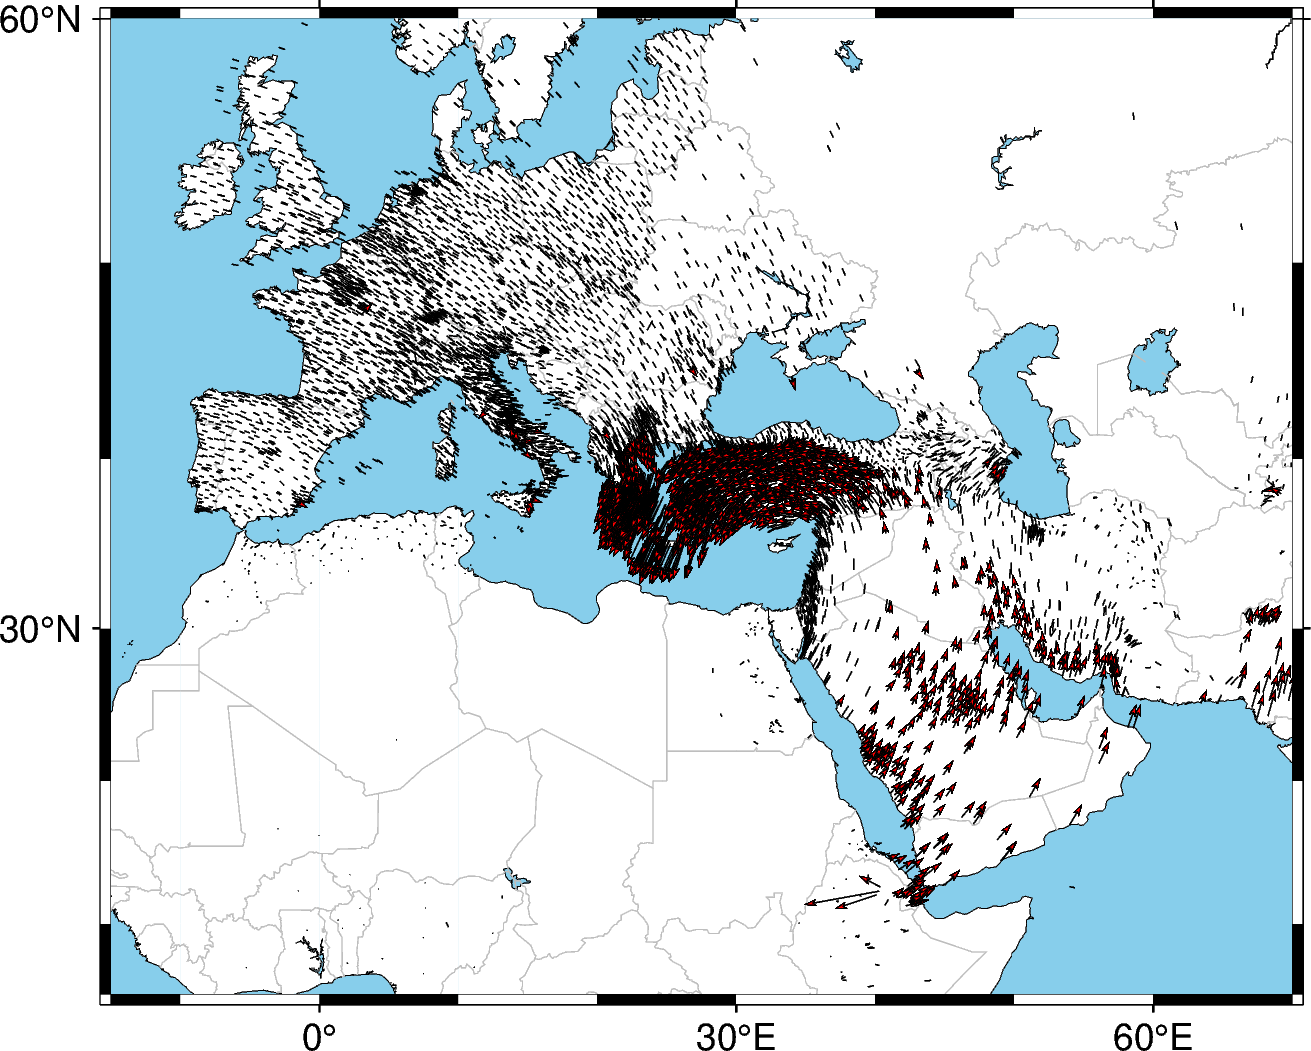

Plotting GPS velocities: combined_vel_sina


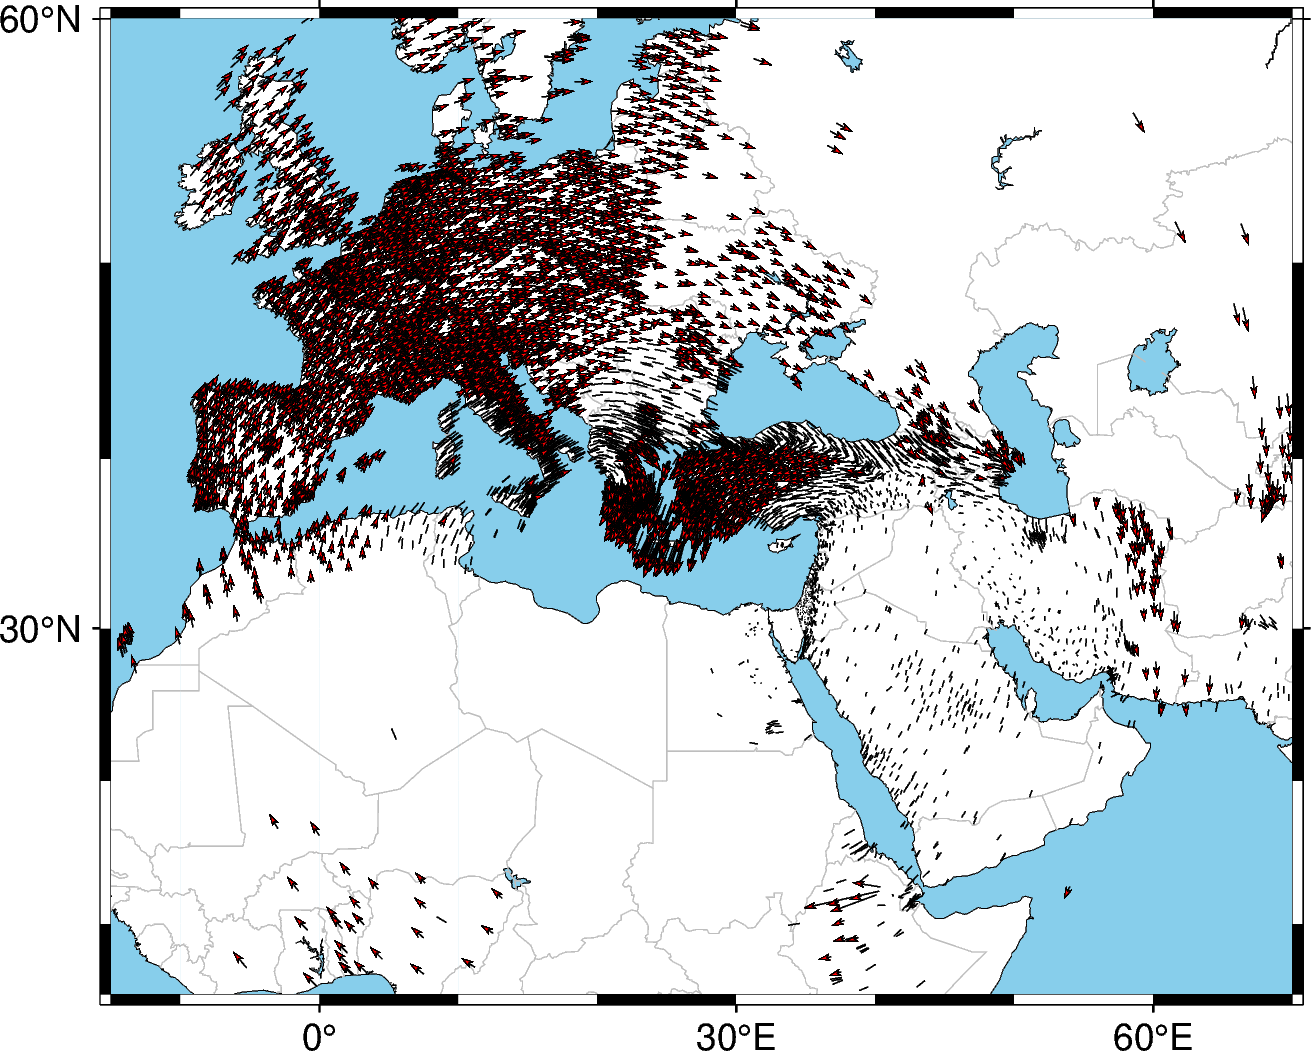

Plotting GPS velocities: combined_vel_igb14


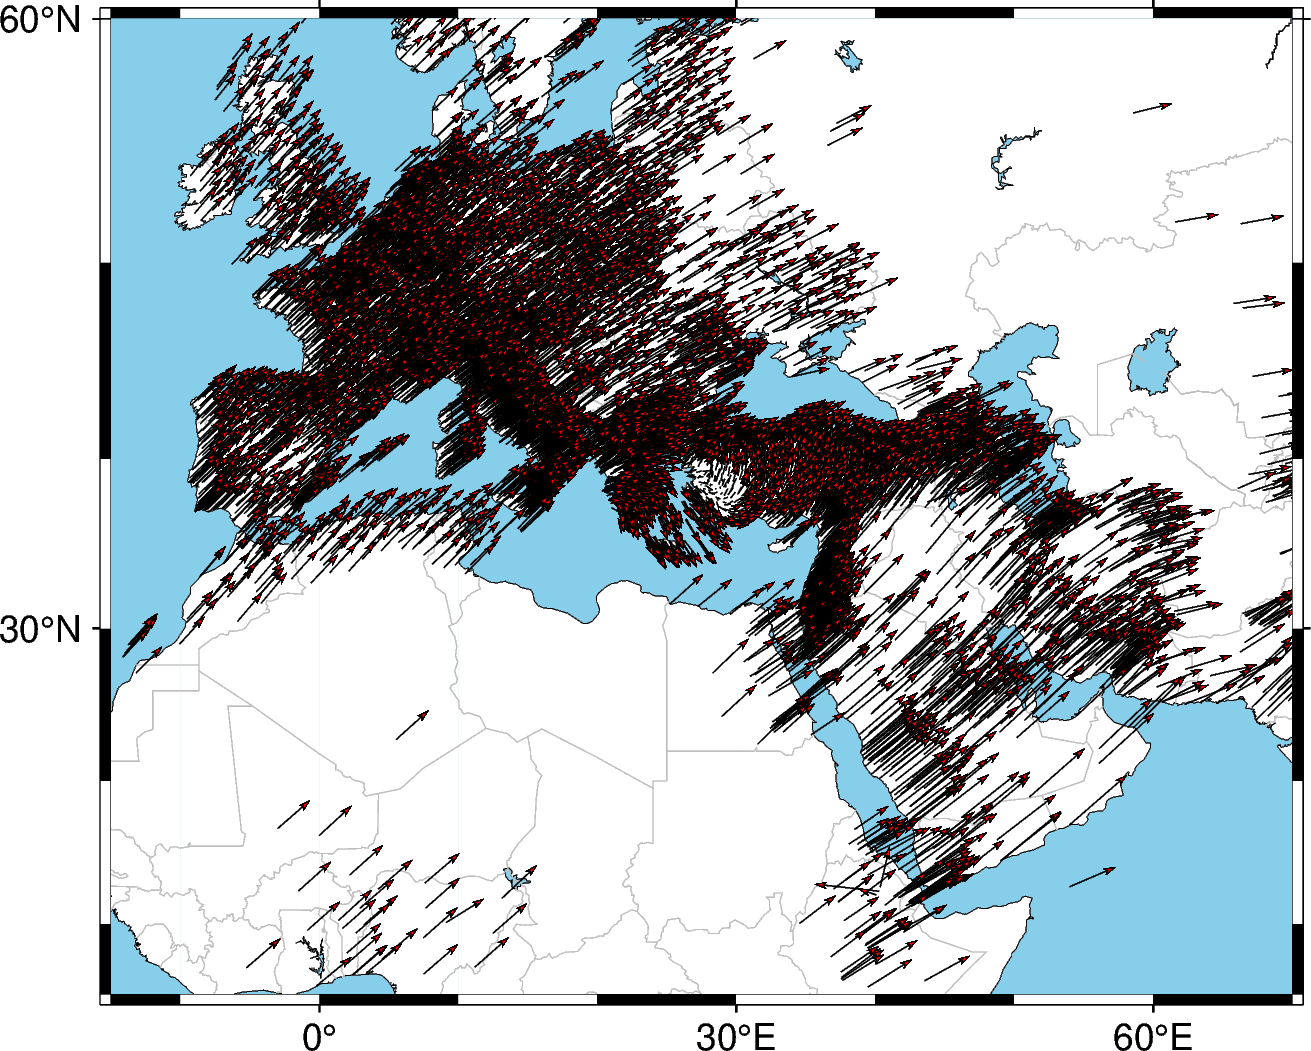

Plotting GPS velocities: combined_vel_eura


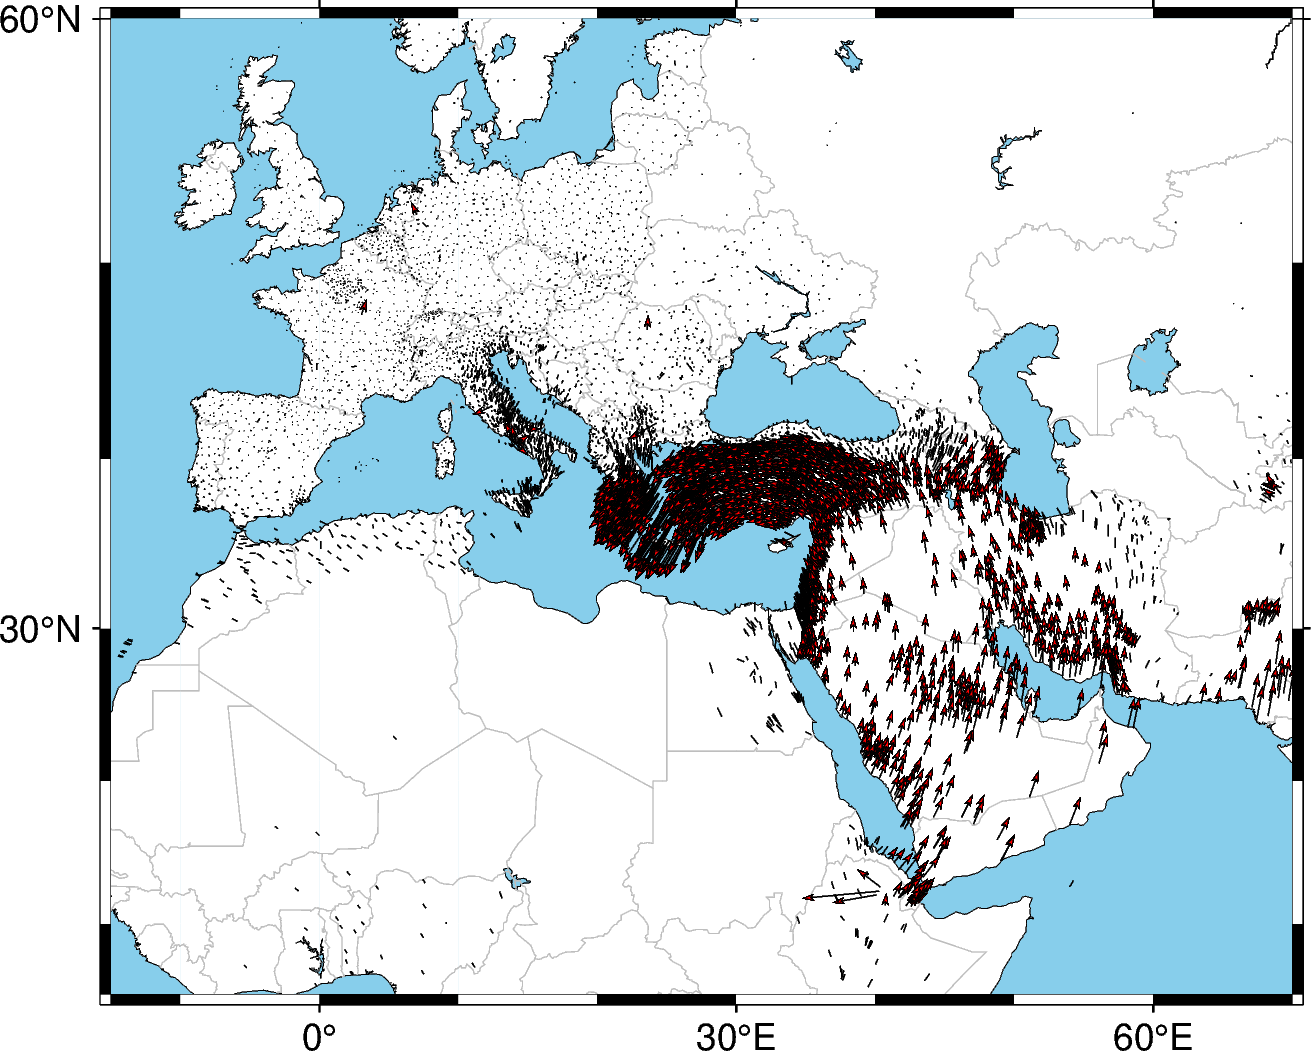

Plotting GPS velocities: combined_vel_anat


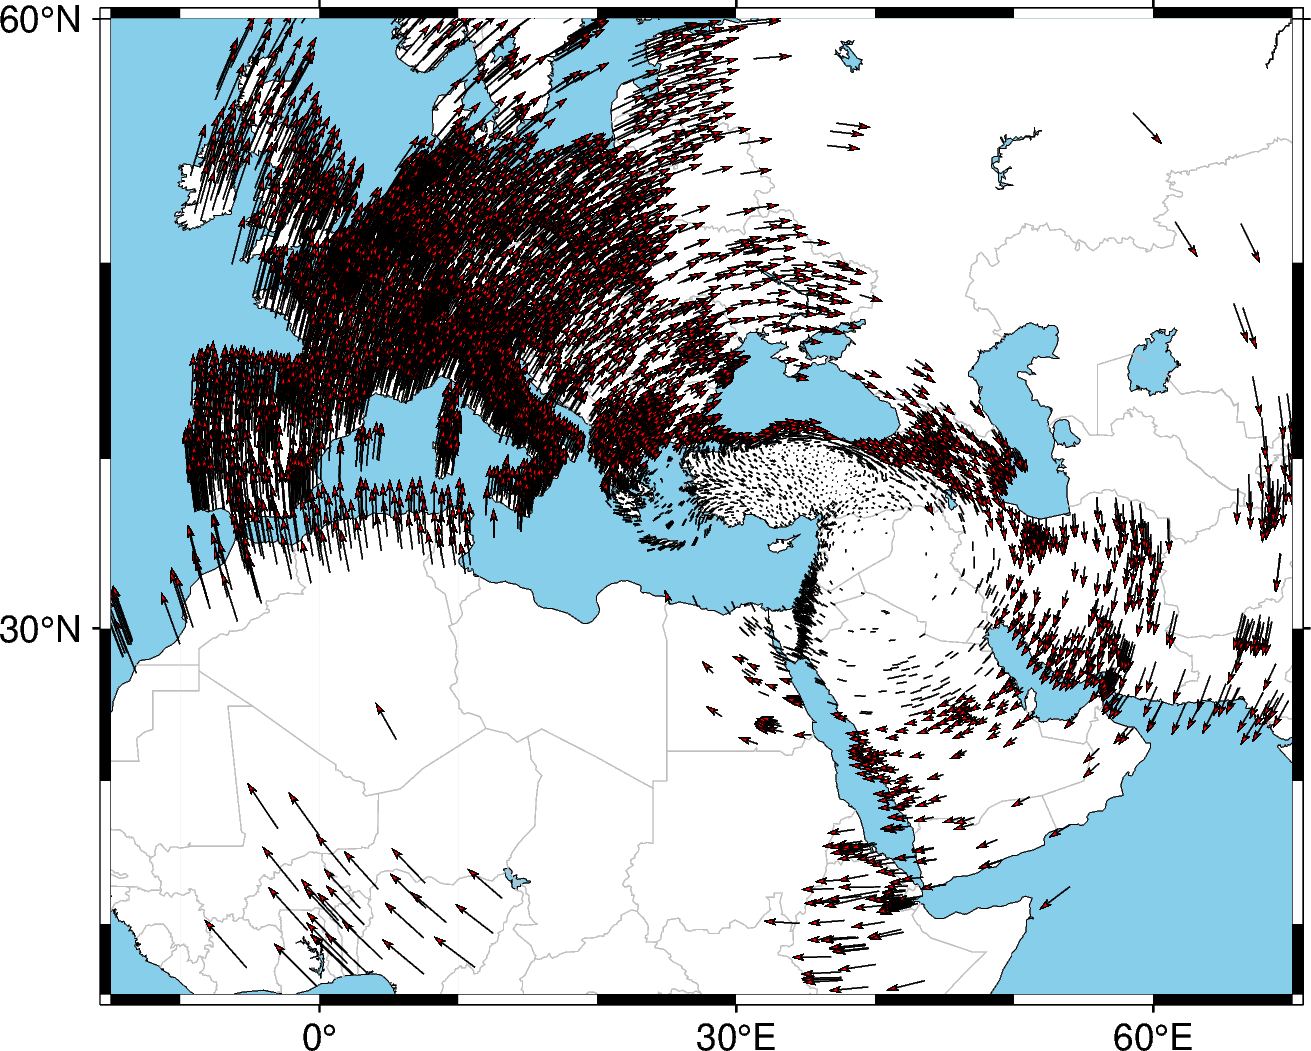

Plotting GPS velocities: combined_vel_arab


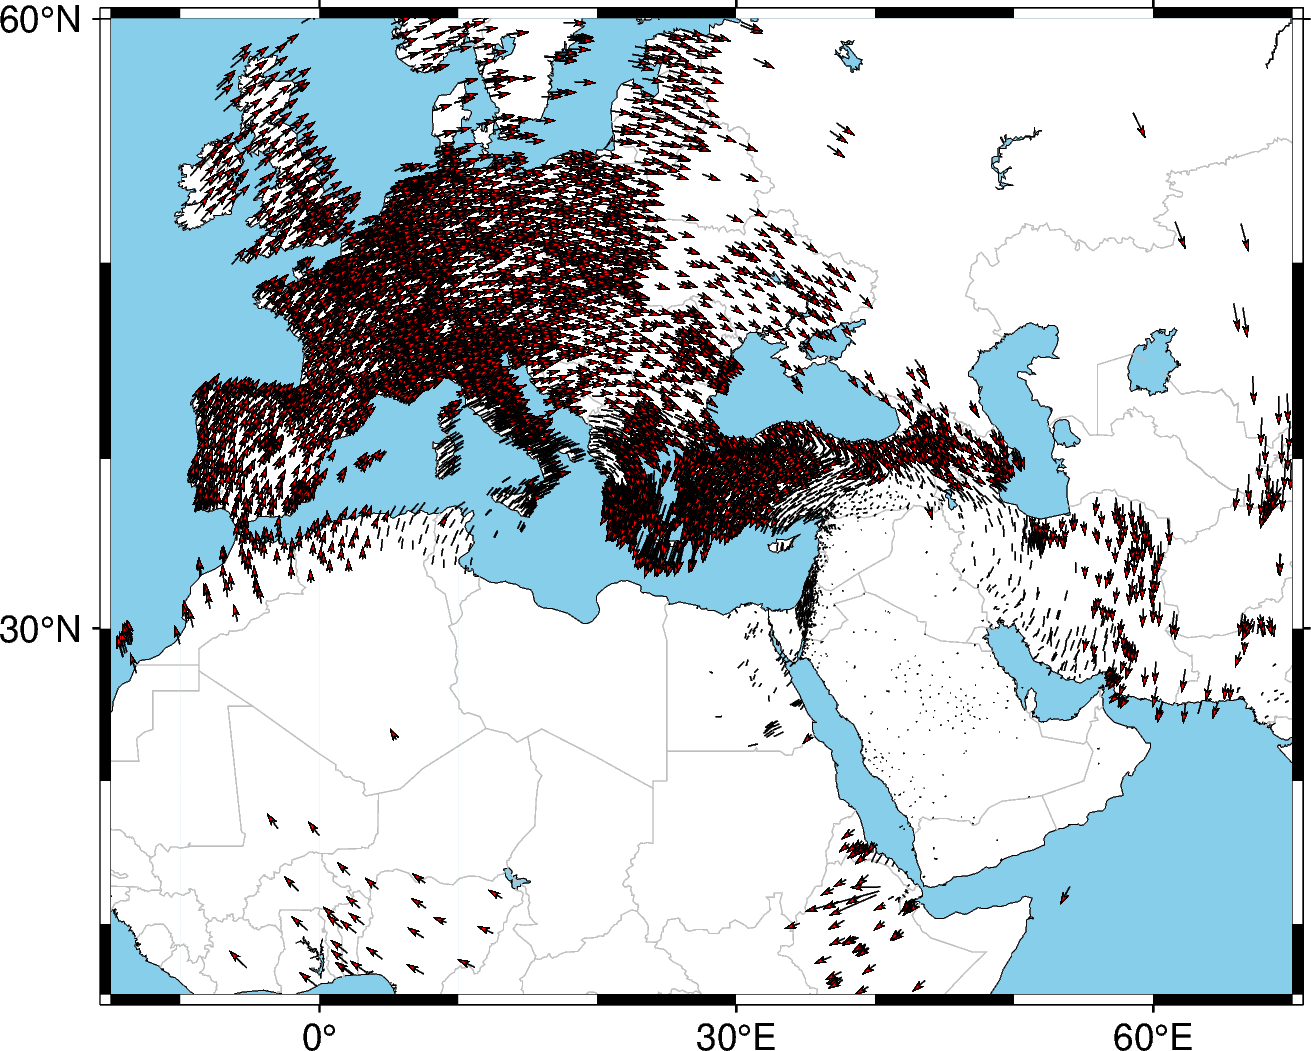

In [9]:
"""Plotting horizontal velocity fields in different reference frames"""

def plot_gps_velocity_fields(folder_path):
    # Find all CSV files in the output_coherence_analysis folder
    file_names = glob.glob(os.path.join(folder_path, '*.csv'))

    # Create a new figure for each file
    for file_name in file_names:
        # Create a new figure
        fig = pygmt.Figure()

        # Set the region and projection of the map
        fig.basemap(region=[-15, 70, 5, 60], projection='M10c', frame='afg')

        # Add coastlines
        fig.coast(land='white', water='skyblue', borders="1/0.2p,gray", shorelines="0.1p,black", area_thresh=4000)

        # Read the CSV file from output_coherence_analysis folder
        df = pd.read_csv(file_name, sep='\s+', skiprows=4, header=None)
        df.columns = ['Lon', 'Lat', 'E.vel', 'N.vel', 'E.adj', 'N.adj', 'E.sig', 'N.sig', 'Corr', 'U.vel', 'U.adj', 'U.sig', 'Stat']

        # Check if the data frame is empty
        if df.shape[0] == 0:
            print(f"Skipping empty file: {file_name}")
            continue
        
        # Filter GPS sites outside the specified region
        df[(df['Lon'] >= -15) & (df['Lon'] <= 70) & (df['Lat'] >= 5) & (df['Lat'] <= 60)]
        
        # Extract the coordinates, E and N velocity components, and E and N sig from the data frame
        lon = df['Lon']
        lat = df['Lat']
        e_vel = df['E.vel']
        n_vel = df['N.vel']
        e_sig = df['E.sig']
        n_sig = df['N.sig']

        # Calculate the velocity magnitude for scaling
        vel_mag = np.sqrt(e_vel**2 + n_vel**2)

        # Normalize the velocity magnitude to the range [0, 1]
        normalized_vel_mag = (vel_mag - vel_mag.min()) / (vel_mag.max() - vel_mag.min())

        # Create a list to store the vectors
        vectors = []

        # Iterate over each site
        for i in range(len(df)):
            x_start = lon[i]
            y_start = lat[i]
            direction_degrees = np.degrees(np.arctan2(n_vel[i], e_vel[i]))
            length = normalized_vel_mag[i] #* 0.5

            # Add the vector to the list
            vectors.append([x_start, y_start, direction_degrees, length])

        # Plot the GPS velocity vectors from output_coherence_analysis folder (blue)
        fig.plot(
            style='v0.1c+e',
            data=vectors,
            fill='red',
            pen='black',
            label='Accepted vel.',
        )

        # Get the base file name without extension
        base_name = os.path.splitext(os.path.basename(file_name))[0]

        
        print(f"Plotting GPS velocities: {base_name}")

        # Show the figure
        fig.show()

# Example usage
input_folder = 'results/combined_velocities'
plot_gps_velocity_fields(input_folder)

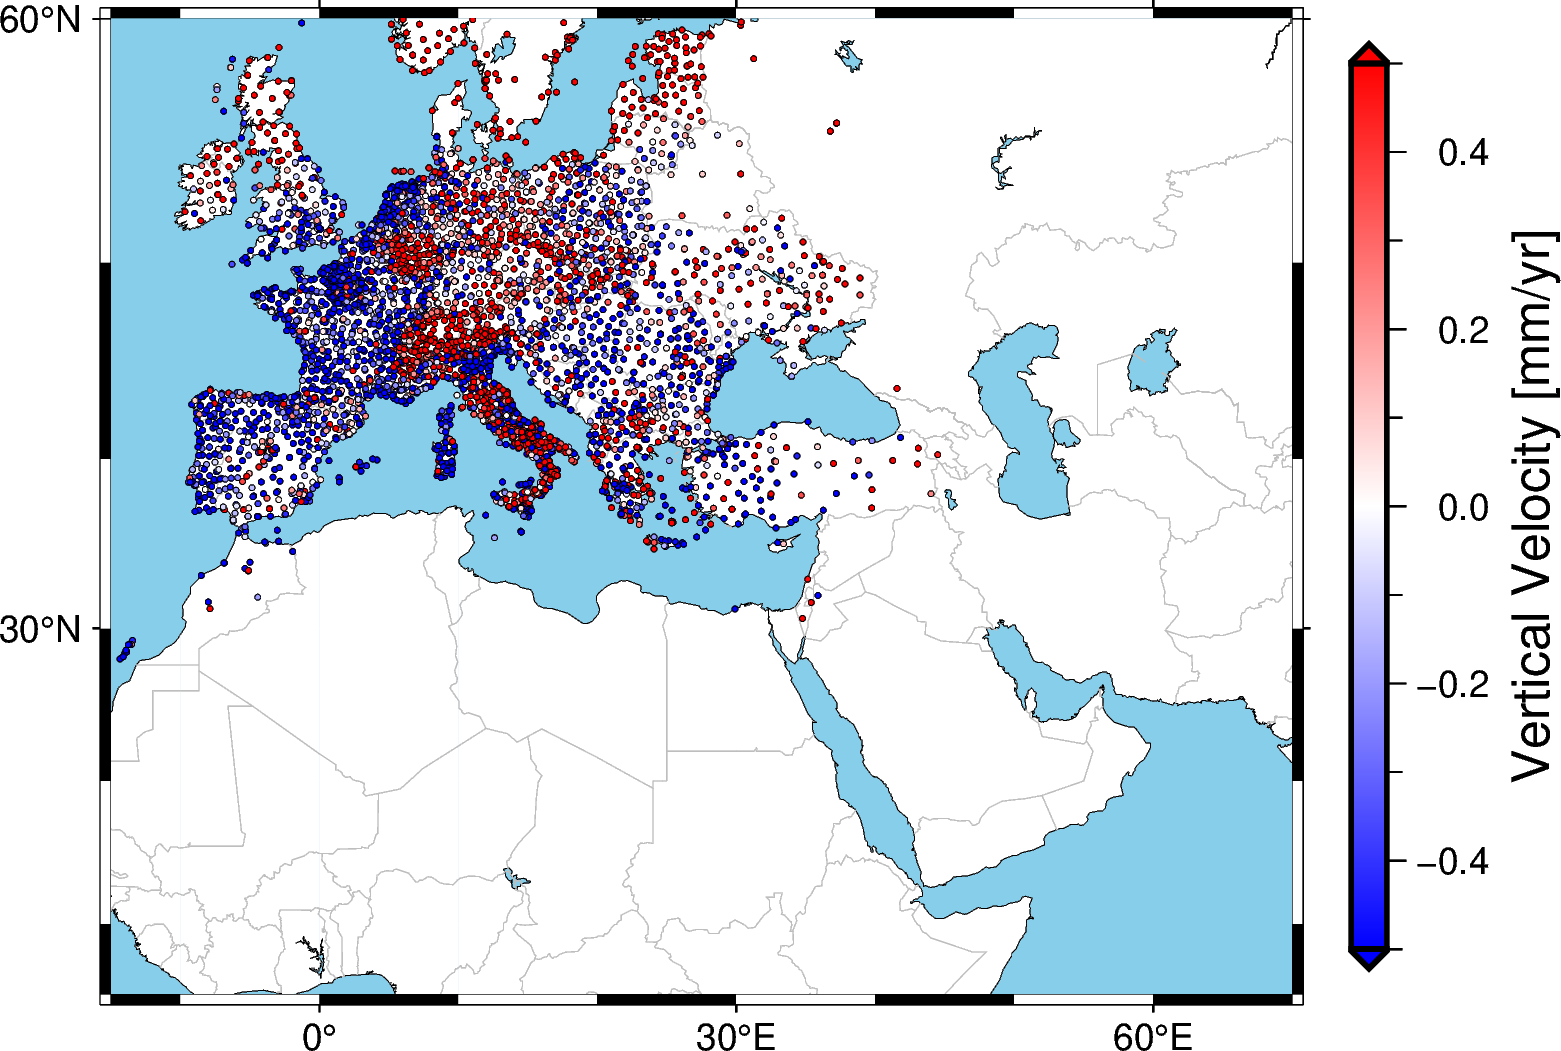

In [3]:
""" Plotting vertical GNSS velocity field """

def plot_vertical_velocity_fields(input_file):

    # Create a new figure
    fig = pygmt.Figure()

    # Set the region and projection of the map
    fig.basemap(region=[-15, 70, 5, 60], projection='M10c', frame='afg')

    # Add coastlines
    fig.coast(land='white', water='skyblue', borders="1/0.2p,gray", shorelines="0.1p,black", area_thresh=4000)

    # Read the CSV file
    df = pd.read_csv(input_file, sep='\s+', skiprows=1, header=None)
    df.columns = ['Lon', 'Lat', 'E.vel', 'N.vel', 'E.adj', 'N.adj', 'E.sig', 'N.sig', 'Corr', 'U.vel', 'U.adj', 'U.sig', 'Stat']

    # Filter GPS sites outside the specified region
    df[(df['Lon'] >= -15) & (df['Lon'] <= 70) & (df['Lat'] >= 5) & (df['Lat'] <= 60)]
   

    # Create circles data with fixed size (e.g., 0.5 cm) and colors based on u_vel
    circles = []
    for lon, lat, norm_u in zip(df['Lon'], df['Lat'], df['U.vel']):
        circles.append([lon, lat, norm_u, 0.05])

   # Create the custom colormap
    pygmt.makecpt(cmap='polar', series=[-0.5, 0.5, 0.01], continuous=True, background=True,)

    # Plot circles with color based on u_vel and fixed size
    fig.plot(
        data=circles,
        style='cc',
        cmap=True,  # This will make use of the custom colormap we created above
        pen='0.01p,black',
    )
    
    # Add a colorbar to the plot
    fig.colorbar(position="JMR+o0.5c/0c+w7.5c+v+e", cmap=True, frame=["a0.1", "+lVertical Velocity [mm/yr]"])

    # Show the figure
    fig.show()


# Call the function
#input_file = './results/combined_velocities/combined_vel_eura.csv'
input_file = './results/input_files_rotation/pinaValdes_2022.vel'
plot_vertical_velocity_fields(input_file)
